<a href="https://colab.research.google.com/github/sauravakolia/Emotion-Detection-Of-Cartoons/blob/master/EmotionDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np 
import argparse
import time

import matplotlib.pyplot as plt

from fastai.vision import *
from google.colab.patches import cv2_imshow


In [19]:
path='/content/drive/My Drive/darknet'
learn = load_learner(path, 'export.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [3]:
%%time
# !rm -r frames/*
!mkdir frames/

#specify path to video
video = "/content/drive/My Drive/darknet/d.mp4"

#capture video
cap = cv2.VideoCapture(video)
cnt=0

# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('/content/frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    # if(cnt==750):
    #   break

  # Break the loop
  else: 
    break

CPU times: user 1min 8s, sys: 1.86 s, total: 1min 10s
Wall time: 1min 7s


In [4]:
net = cv2.dnn.readNet("/content/drive/My Drive/darknet/backup/yolov3_custom_final.weights", "/content/drive/My Drive/darknet/cfg/yolov3_custom.cfg")
classes = []
with open("/content/drive/My Drive/darknet/obj.names", "r") as f:
	classes = [line.strip() for line in f.readlines()]
print(classes)  

['Tom', 'Jerry']


In [0]:

#Load yolo
def load_yolo():
	net = cv2.dnn.readNet("/content/drive/My Drive/darknet/backup/yolov3_custom_final.weights", "/content/drive/My Drive/darknet/cfg/yolov3_custom.cfg")
	classes = []
	with open("/content/drive/My Drive/darknet/obj.names", "r") as f:
		classes = [line.strip() for line in f.readlines()]

	layers_names = net.getLayerNames()
	output_layers = [layers_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
	colors = np.random.uniform(0, 255, size=(len(classes)+1, 3))
	return net, classes, colors, output_layers




In [0]:

def load_image(img_path):
	# image loading
	img = cv2.imread(img_path)
	img = cv2.resize(img, None, fx=0.4, fy=0.4)
	height, width, channels = img.shape
	# print(height)
	return img, height, width, channels



In [0]:
def display_blob(blob):
  for b in blob:
    for n, imgb in enumerate(b):
      cv2_imshow(imgb)
	# for b in blob:
	# 	for n, imgb in enumerate(b):
  #     plt.imshow(str(n), imgb)
	# 		# cv2.imshow(str(n), imgb)



In [0]:
def detect_objects(img, net, outputLayers):			
	blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(320, 320), mean=(0, 0, 0), swapRB=True, crop=False)
	net.setInput(blob)
	outputs = net.forward(outputLayers)
	return blob, outputs



In [0]:
def get_box_dimensions(outputs, height, width):
	boxes = []
	confs = []
	class_ids = []
	# print(len(outputs))
	
	for output in outputs:
		for detect in output:
			scores = detect[5:]
			class_id = np.argmax(scores)
			# print(class_id)
			
			
	 
			conf = scores[class_id]
			if conf > 0.3 :
				center_x = int(detect[0] * width)
				center_y = int(detect[1] * height)
				w = int(detect[2] * width)
				h = int(detect[3] * height)
				x = int(center_x - w/2)
				y = int(center_y - h / 2)
				boxes.append([x, y, w, h])
				confs.append(float(conf))
				class_ids.append(class_id)
	# print("boxes")
	# print((boxes))
 
	return boxes, confs, class_ids
			




In [0]:
def draw_labels(boxes, confs, colors, class_ids, classes, img): 
  indexes=cv2.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
  midpoint=[]
  ind=[]
  ind1=[]
  for x in indexes:
    ind1.append(x[0])
  # print(type(indexes))
  if( len(indexes)==0 ):
    return img;
  font=cv2.FONT_HERSHEY_SIMPLEX
  for i in range(len(boxes)):
    
    if i in indexes:
      # cv2_imshow(img)
      x,y, w, h = boxes[i]
      if(x<0):
        x=0
      if(y<0):
        y=0
      if(w<0):
        w=0
      if(h<0):
        h=0     
      label=str(classes[class_ids[i]])
      color=colors[i]
      # print(colors)
      # print(x,y,w,h)
      img_cp=img[y:y+h,x:x+w]  
      # cv2_imshow(img_cp)

      prediction, idx, probability = learn.predict(Image(pil2tensor(img_cp, np.float32).div_(225)))
      # print(prediction)

      cv2.rectangle(img, (x,y), (x+w, y+h), color, 1)
      cv2.putText(img,str(prediction),(x, y - 5), font, 0.7, color, 1)
      # cv2_imshow(img)
      return img
      

In [0]:

def image_detect(img_path): 
	model, classes, colors, output_layers = load_yolo()
	image, height, width, channels = load_image(img_path)
	blob, outputs = detect_objects(image, model, output_layers)
	boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
	img=draw_labels(boxes, confs, colors, class_ids, classes, image)
	cv2_imshow(img)


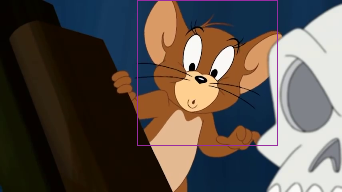

In [12]:
image_detect('/content/frames/255.png')

In [0]:
def start_video(name):
	image = cv2.imread('frames/'+name)
	model, classes, colors, output_layers = load_yolo()
	image, height, width, channels = load_image('frames/'+name)
	blob, outputs = detect_objects(image, model, output_layers)
	boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
	img=draw_labels(boxes, confs, colors, class_ids, classes, image)
	cv2.imwrite('/content/frames/'+name,img)

		

In [20]:
import os
import re

names=os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))
names

['0.png',
 '1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png',
 '10.png',
 '11.png',
 '12.png',
 '13.png',
 '14.png',
 '15.png',
 '16.png',
 '17.png',
 '18.png',
 '19.png',
 '20.png',
 '21.png',
 '22.png',
 '23.png',
 '24.png',
 '25.png',
 '26.png',
 '27.png',
 '28.png',
 '29.png',
 '30.png',
 '31.png',
 '32.png',
 '33.png',
 '34.png',
 '35.png',
 '36.png',
 '37.png',
 '38.png',
 '39.png',
 '40.png',
 '41.png',
 '42.png',
 '43.png',
 '44.png',
 '45.png',
 '46.png',
 '47.png',
 '48.png',
 '49.png',
 '50.png',
 '51.png',
 '52.png',
 '53.png',
 '54.png',
 '55.png',
 '56.png',
 '57.png',
 '58.png',
 '59.png',
 '60.png',
 '61.png',
 '62.png',
 '63.png',
 '64.png',
 '65.png',
 '66.png',
 '67.png',
 '68.png',
 '69.png',
 '70.png',
 '71.png',
 '72.png',
 '73.png',
 '74.png',
 '75.png',
 '76.png',
 '77.png',
 '78.png',
 '79.png',
 '80.png',
 '81.png',
 '82.png',
 '83.png',
 '84.png',
 '85.png',
 '86.png',
 '87.png',
 '88.png',
 '89.png',
 '90.png',
 '91.png'

In [16]:
from tqdm import tqdm
_ = [start_video(names[i]) for i in tqdm(range(len(names))) ]

100%|██████████| 4509/4509 [1:46:41<00:00,  1.42s/it]


In [22]:
%%time
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    
    #reading each files
    img = cv2.imread('frames/'+frames[i])
    # img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('sample_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

CPU times: user 8.56 s, sys: 345 ms, total: 8.91 s
Wall time: 8.93 s
